In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#from datasets import load_dataset

sns.set(style="whitegrid", palette="cubehelix", font_scale=1.2)
plt.style.use("ggplot")
palette = sns.color_palette('cubehelix')

In [52]:
splits = {'train': 'patent/train-00000-of-00001.parquet', 'validation': 'patent/validation-00000-of-00001.parquet', 'test': 'patent/test-00000-of-00001.parquet'}
df_train = pd.read_parquet("hf://datasets/ccdv/patent-classification/" + splits["train"])
df_val = pd.read_parquet("hf://datasets/ccdv/patent-classification/" + splits["validation"])
df_test = pd.read_parquet("hf://datasets/ccdv/patent-classification/" + splits["test"])

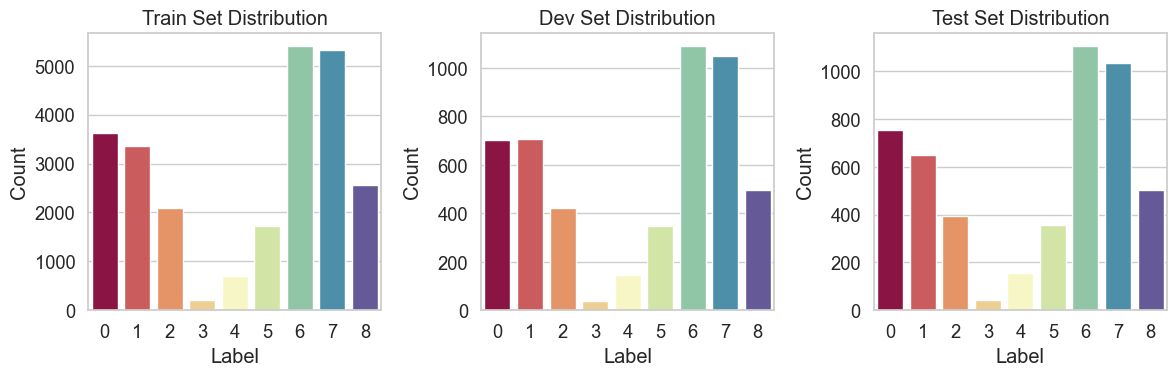

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set seaborn style
sns.set(style="whitegrid", palette="Spectral", font_scale=1.2)

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))  # Wider for better spacing

# Loop through datasets
for i, (df, label) in enumerate(zip([df_train, df_val, df_test], ['Train', 'Dev', 'Test'])):
    sns.countplot(data=df, x='label', hue='label', ax=axs[i], palette='Spectral', legend=False)
    axs[i].set_title(f'{label} Set Distribution')
    axs[i].set_xlabel('Label')
    axs[i].set_ylabel('Count')

# Layout and show
plt.tight_layout()
plt.show()


/var/folders/fz/1mp_qssx1z546qc9z63nq3rm0000gn/T/ipykernel_9762/1596057978.py:10: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) Arial.
  plt.tight_layout()
/Users/luciasauer/Desktop/3term/nlp/final_project/anlp_final_project/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128221 (\N{MEMO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


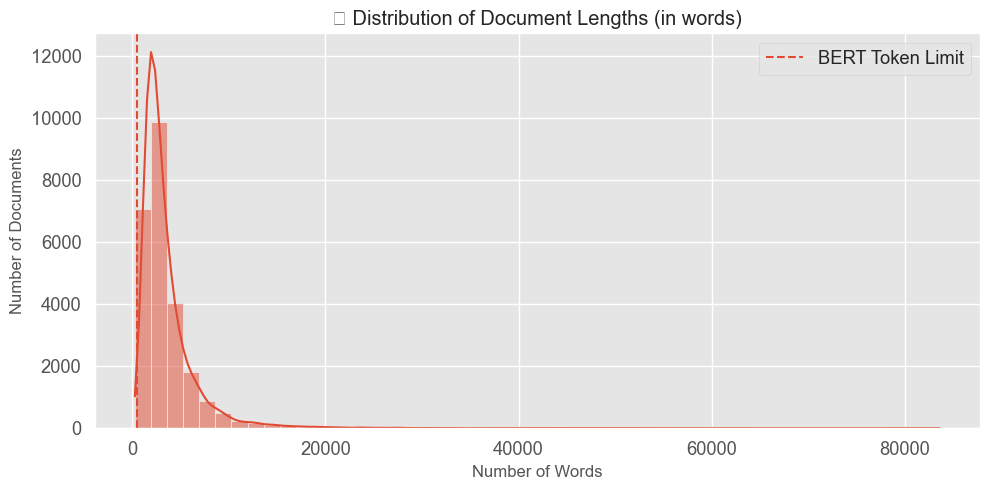

In [17]:
# 2. Document length distribution
df['text_length'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(10, 5))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.axvline(x=512,  linestyle='--', label='BERT Token Limit')
plt.title('📝 Distribution of Document Lengths (in words)')
plt.xlabel('Number of Words')
plt.ylabel('Number of Documents')
plt.legend()
plt.tight_layout()
plt.show()